# Traffic Volumes - Turning Movement Counts (TMCs) Bikes
# Identifying Extreme Values 

In [2]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as ticker

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

## Checking for Extreme Values 

Create a histogram of volume numbers to determine which values are "extreme" 

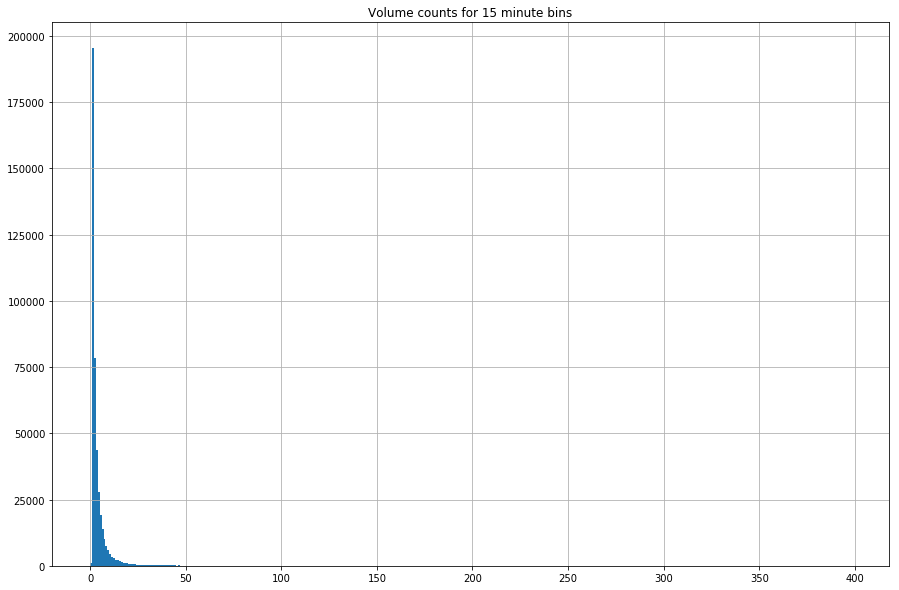

In [3]:
sql_volumes = '''
SELECT volume_15min
FROM open_data.volumes_tmc_bikes
'''
volumes = pandasql.read_sql(sql_volumes, con)


bin_val = np.arange(min(volumes['volume_15min']), max(volumes['volume_15min']), 1)

volumes.hist(bins=bin_val, figsize=(15,10))
plt.title('Volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)

There are some values greater than 20, but it is hard to see how many of these larger volumes exist. Create a new histogram to zoom into the volumes that are greater than 20.

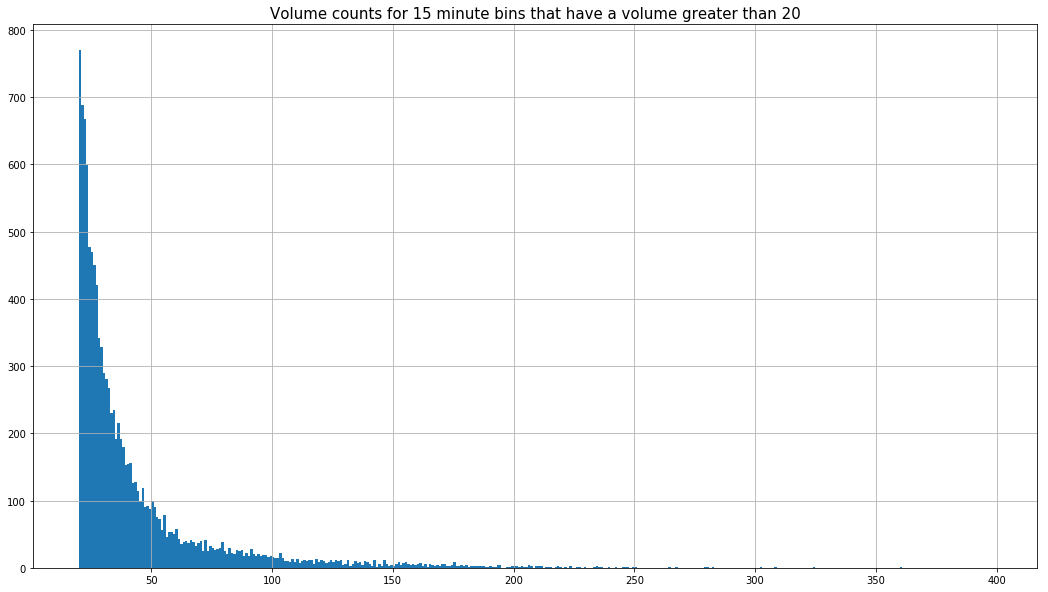

In [4]:
volumes.hist(bins = np.arange(20,  max(volumes['volume_15min']), 1), figsize=(18,10))
plt.title('Volume counts for 15 minute bins that have a volume greater than 20')
ax = plt.gca()
f = lambda x,pos: str(x).rstrip('0').rstrip('.')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)

Looking at the above histogram, it is still tough to see the number of records with a volume above 70.

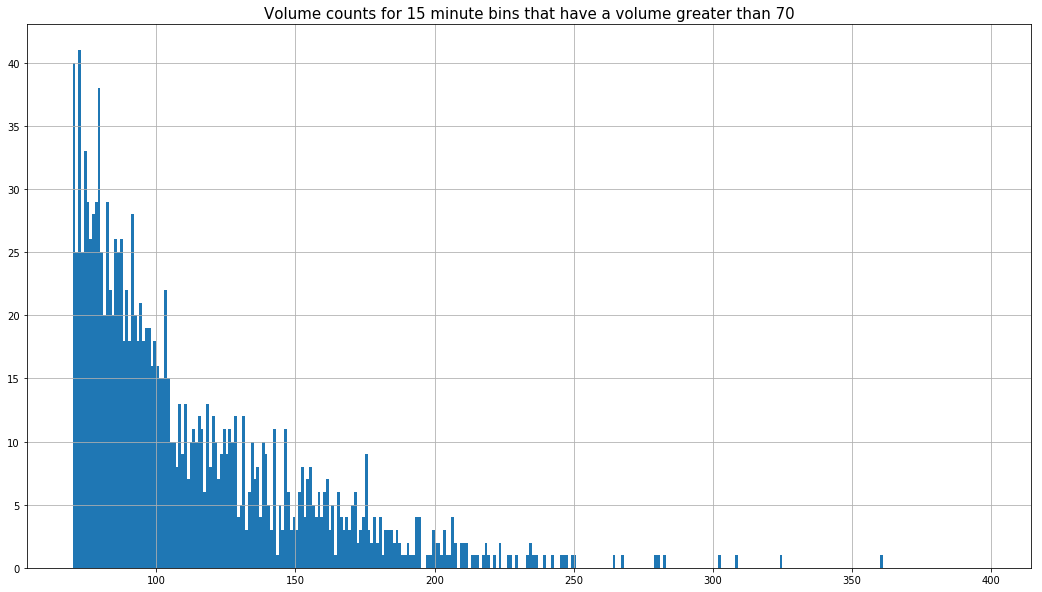

In [5]:
volumes.hist(bins = np.arange(70, max(volumes['volume_15min']) , 1), figsize=(18,10))
plt.title('Volume counts for 15 minute bins that have a volume greater than 70')
ax = plt.gca()
f = lambda x,pos: str(x).rstrip('0').rstrip('.')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)

The trend is that the volumes are gradually decreasing. Even the highest volume values in the dataset do not seem to be incorrect or out of place because of the trend

# Removing outliers from dataset

In [34]:
sql_volumes = '''
SELECT px, location, class_type, leg,  (CASE WHEN movement IS NULL THEN 'None' ELSE movement END) AS movement, 
datetime_bin, volume_15min 
FROM open_data.volumes_tmc_bikes
'''

sql_locations = '''
SELECT DISTINCT ON (px, leg, movement) px, leg, (CASE WHEN movement IS NULL THEN 'None' ELSE movement END) AS movement
FROM open_data.volumes_tmc_bikes
'''

locations = pandasql.read_sql(sql_locations, con)

In [35]:
volumes = pandasql.read_sql(sql_volumes, con)

In [36]:
final_df = pd.DataFrame(columns=[ 'px', 'location', 'class_type', 'leg', 'movement', 'datetime_bin', 'volume_15min' ])
old_outliers = pd.DataFrame(columns=[ 'px', 'location', 'class_type', 'leg', 'movement', 'datetime_bin', 'volume_15min' ])

# test to make sure these outliers will be caught
#d = {'px':[2, 275], 'location':['Front / Jarvis', "Richmond / Spadina"], 'class_type':['Cylcists', "Cyclists"], 'leg':['E', 'E'], 
#  'movement':['Through', "Through"], 'datetime_bin':['2017-10-31 13:00:00', "2018-11-07 17:15:00"], 'volume_15min':[60, 400] }   
#df = pd.DataFrame(data=d)
#volumes = volumes.append(df)


for row in locations.itertuples():
    subset = volumes.loc[ (volumes['px'] == row.px) & (volumes['leg'] == row.leg) & (volumes['movement'] == row.movement)]
    
    
    p25, p75 = np.percentile(subset['volume_15min'], 25), np.percentile(subset['volume_15min'], 75)
    iqr = p75 - p25

    # calculate outlier cut off 
    # if volume value is not between lower and upper than it will be considered an outlier
    cut_off = iqr*1.5
    lower, upper = int(p25 - cut_off), int(p75 + cut_off)
    # we cannot have a negative traffic volume
    if lower < 0: 
        lower = 0
    
    # identify outliers
    frames = [old_outliers, subset.loc[(subset['volume_15min'] < lower) | (subset['volume_15min'] > upper)  ]  ]
    old_outliers = pd.concat(frames)
    
    
    # all records that are not outliers
    frames = [final_df, subset.loc[(subset['volume_15min'] >= lower) & (subset['volume_15min'] <= upper)]  ]
    final_df = pd.concat(frames)


Other percentile values (instead of 75 and 25) such as 90 and 10, 95 and 5, 90 and 5 were tested, but similar results were found in the end. These results included there being a huge amount of outliers that have values between 2 and 4, which are not "extreme values". I also had to edit the views so that the movement field is never null.

In [37]:
# get percentage of total records that are outliers 
(len(old_outliers.index) / len(volumes.index))*100 

8.674626344974477

In [38]:
# QC checks
print((len(old_outliers.index) + len(final_df.index)) == len(volumes.index))

True


The percentage of outliers is too high. Investigate outliers to determine if they really are outliers that should be removed from analysis.

## Investigating outliers

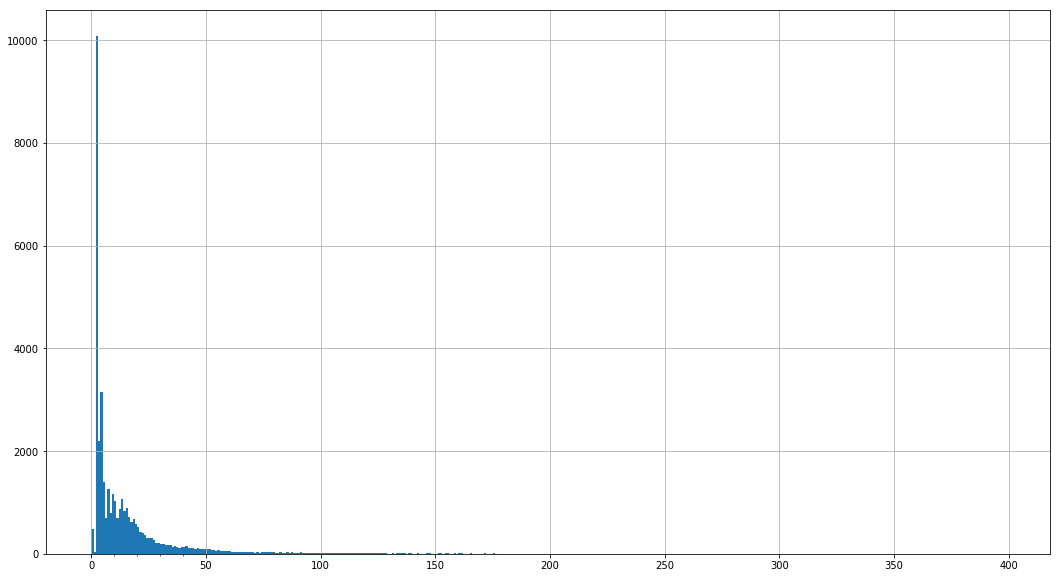

In [39]:
old_outliers['volume_15min'].hist(bins = np.arange(0, max(old_outliers['volume_15min']) , 1), figsize = (18, 10))
ax = plt.gca()
minor_ticks = np.arange(0, 50, 10)
major_ticks = np.arange(0, 50, 100)

#ax.set_xticks(major_ticks, labels=[major_ticks])
ax.set_xticks(minor_ticks, minor=True)

In [40]:
#outliers

# 40% of outliers are equal to the value of 2
# 8% equal 3
subset_outliers = old_outliers.loc[(old_outliers['volume_15min']  == 2) | (old_outliers['volume_15min']  == 4) ]
len(subset_outliers.index)/len(old_outliers.index)*100

34.97817171583543

## Incorporating analysis by date

The volumes were already being analysed by location, movement, and leg. This means that the volumes for every distinct location, movement and leg, were being analysed for outliers. Now we also want to inlcude month and hour into the analysis in order to see if this type of analysis will yield more accurate outlier results.

In [41]:
sql_volumes = '''
SELECT px, location, class_type, leg, (CASE WHEN movement IS NULL THEN 'None' ELSE movement END) AS movement, 
datetime_bin, volume_15min,  
date_part('month', datetime_bin) AS month, date_part('hour', datetime_bin) AS hour
FROM open_data.volumes_tmc_bikes
'''

sql_locations = '''
SELECT DISTINCT ON (px, leg, movement, date_part('month', datetime_bin), date_part('hour', datetime_bin)) 
px, leg, (CASE WHEN movement IS NULL THEN 'None' ELSE movement END) AS movement, date_part('month', datetime_bin) AS month, 
date_part('hour', datetime_bin) AS hour
FROM open_data.volumes_tmc_bikes
'''

locations = pandasql.read_sql(sql_locations, con)

In [42]:
volumes = pandasql.read_sql(sql_volumes, con)

In [43]:
final_df = pd.DataFrame(columns=[ 'px', 'location', 'class_type', 'leg', 'movement', 'datetime_bin', 'volume_15min', 'month', 'hour' ])
outliers = pd.DataFrame(columns=[ 'px', 'location', 'class_type', 'leg', 'movement', 'datetime_bin', 'volume_15min', 'month', 'hour'])

for row in locations.itertuples():
    subset = volumes.loc[ (volumes['px'] == row.px) & (volumes['leg'] == row.leg) & (volumes['movement'] == row.movement)
                        & (volumes['month'] == row.month)  & (volumes['hour'] == row.hour) ]

    p25, p75 = np.percentile(subset['volume_15min'], 25), np.percentile(subset['volume_15min'], 75)
    iqr = p75 - p25

    # calculate outlier cut off 
    # if volume value is not between lower and upper than it will be considered an outlier
    cut_off = iqr*1.5
    lower, upper = int(p25 - cut_off), int(p75 + cut_off)
    # we cannot have a negative traffic volume
    if lower < 0: 
        lower = 0
    
    # identify outliers
    frames = [outliers, subset.loc[(subset['volume_15min'] < lower) | (subset['volume_15min'] > upper)]  ]
    outliers = pd.concat(frames)
    
    
    # all records that are not outliers
    frames = [final_df, subset.loc[(subset['volume_15min'] >= lower) & (subset['volume_15min'] <= upper)]  ]
    final_df = pd.concat(frames)

In [44]:
# get percentage of total records that are outliers 
(len(outliers.index) / len(volumes.index))*100

4.308049649296757

In [45]:
# QC checks
print((len(outliers.index) + len(final_df.index)) == len(volumes.index))

True


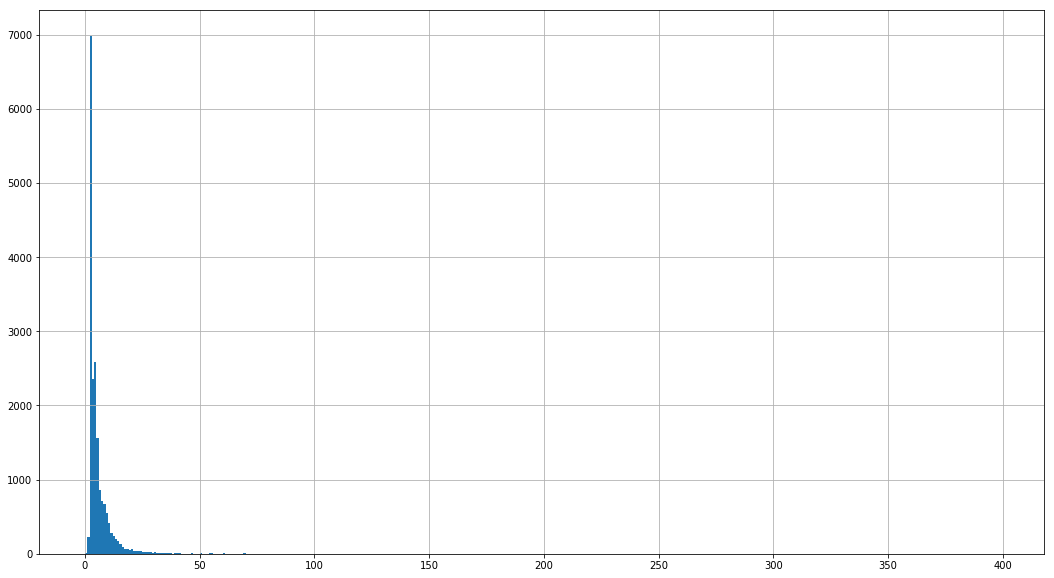

In [46]:
outliers['volume_15min'].hist(bins = np.arange(min(outliers['volume_15min']), 
                                               max(outliers['volume_15min']), 1), figsize = (18, 10))

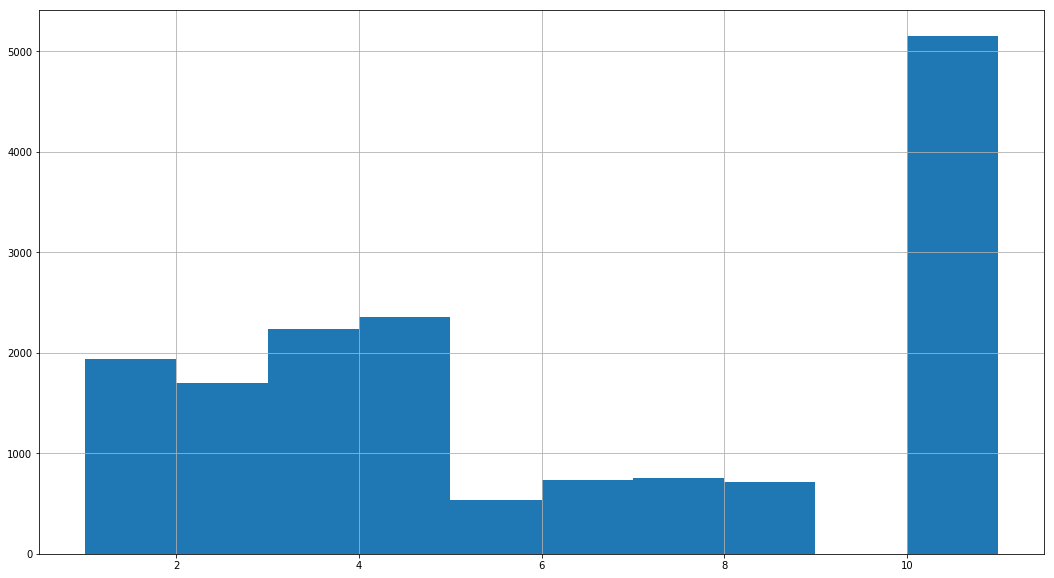

In [47]:
outliers['month'].hist(bins = np.arange(min(outliers['month']), 
                                               max(outliers['month']), 1), figsize = (18, 10))

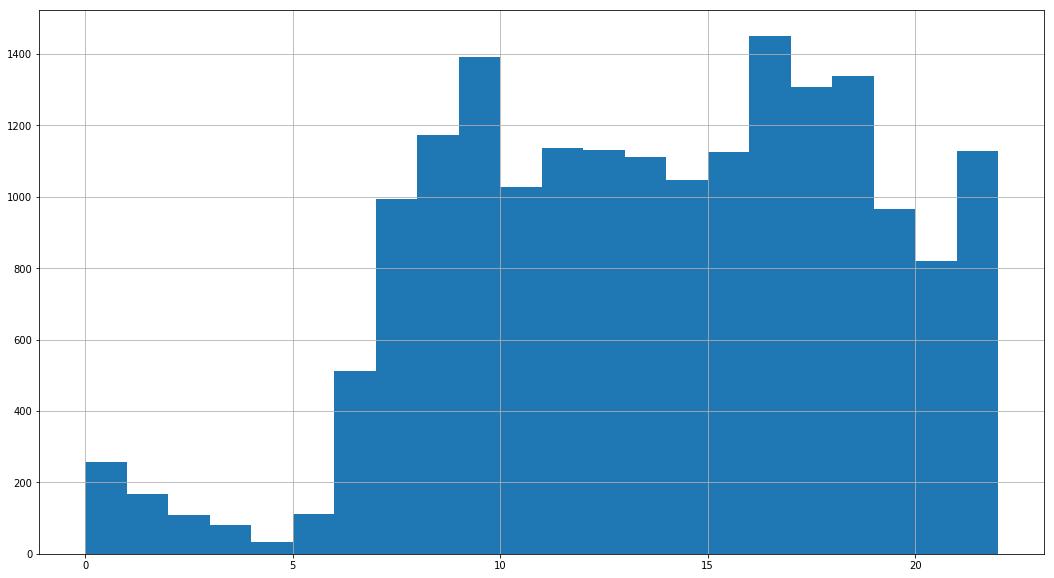

In [48]:
outliers['hour'].hist(bins = np.arange(min(outliers['hour']), 
                                               max(outliers['hour']), 1), figsize = (18, 10))

In [49]:
# 39% of outliers are equal to the value of 2
# 12% equal 3
subset_outliers = outliers.loc[(outliers['volume_15min']  == 2)  | (outliers['volume_15min']  == 3) ]
len(subset_outliers.index)/len(outliers.index)*100

49.76558337773042

## Look at outliers and the 95th percentile values at their locations

In [58]:
# get each location, leg, movement and the 95th percentile of the 15 min bin volumes 
sql_volumes = '''
SELECT px, leg, (CASE WHEN movement IS NULL THEN 'None' ELSE movement END) AS movement,
PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min ASC) as percentile_95
FROM open_data.volumes_tmc_bikes
GROUP BY px, location,leg, (CASE WHEN movement IS NULL THEN 'None' ELSE movement END)
'''

percentile_95 = pandasql.read_sql(sql_volumes, con)

In [59]:
# join outlier data frame to data frame with the 95th percentile of locations
pd.merge(outliers, percentile_95, how='inner', on='px')

,px,location,class_type,leg_x,movement_x,datetime_bin,volume_15min,month,hour,leg_y,movement_y,percentile_95
0,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,E,Left,2.00
1,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,E,None,3.00
2,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,E,Right,2.00
3,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,E,Through,7.00
4,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,N,Left,2.00
5,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,N,None,3.00
6,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,N,Right,2.00
7,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,N,Through,3.00
8,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,S,Left,1.05
9,2,Front / Jarvis,Cyclists,E,None,2018-01-20 09:15:00,2,1.0,9.0,S,None,2.00


The 95$^{th}$ percentile values at these locations are volumes that may be high or low compared to the other bike volumes recorded at these locations. However, the volumes are not extreme values (i.e. so high that the volume count would be impossible and that there must have been a malfunction with the volume recording devices). 

## Conclusion 

After looking at the analysis including date and hour, the outliers identified in both analyses do not seem to be "extreme values" (i.e. incorrect volumes collected). Therefore no "extreme values" records need to be removed from the dataset.